In [ ]:
# CELL 1: INSTALASI LIBRARY & GPU SETUP

!pip install pandas transformers seaborn matplotlib tqdm openpyxl scikit-learn ipywidgets
# Install PyTorch khusus CUDA (GPU)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
# CELL 2: IMPORT & KONFIGURASI PATH

import os
import glob
import re
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm.auto import tqdm

# Setup Tampilan Grafik
sns.set_style("whitegrid")
%matplotlib inline

# --- KONFIGURASI FOLDER ---
# Input: Mengarah ke folder DatasetHotelCLEAN (naik 1 level dari src)
INPUT_DATA_PATH = '../DatasetHotelCLEAN' 

# Output: Folder Results
OUTPUT_CSV_PATH = '../Results/CSV'
OUTPUT_IMG_PATH = '../Results/Visualisasi'

# Buat folder output otomatis
os.makedirs(OUTPUT_CSV_PATH, exist_ok=True)
os.makedirs(OUTPUT_IMG_PATH, exist_ok=True)

# Kategori Topik untuk AI
CANDIDATE_LABELS = [
    "Kualitas Makanan & Restoran",      
    "Kebersihan & Kenyamanan Kamar",    
    "Pelayanan Staf & Keramahan",       
    "Fasilitas Hotel (Kolam/Gym/Spa)",  
    "Lokasi & Akses Strategis",         
    "Infrastruktur (AC/WiFi/Parkir/Air)", 
    "Harga & Value for Money"           
]

print("Konfigurasi Selesai.")
print(f"Input Data: {INPUT_DATA_PATH}")
print(f"Simpan CSV: {OUTPUT_CSV_PATH}")
print(f"Simpan PNG: {OUTPUT_IMG_PATH}")

Konfigurasi Selesai.
Input Data: ../DatasetHotelCLEAN
Simpan CSV: ../Results/CSV
Simpan PNG: ../Results/Visualisasi


In [2]:
# CELL 3: LOAD MODEL AI (INDOBERT)

def setup_models():
    print("Memuat Model AI...")
    
    device = 0 if torch.cuda.is_available() else -1
    if device == 0:
        print(f"GPU Terdeteksi: {torch.cuda.get_device_name(0)}")
    else:
        print("GPU Tidak Terdeteksi. Menggunakan CPU.")

    # Model IndoBERT (Sentimen) & mDeBERTa (Topik)
    model_sentiment = "w11wo/indonesian-roberta-base-sentiment-classifier"
    model_zeroshot = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"

    try:
        clf_sentiment = pipeline("sentiment-analysis", model=model_sentiment, tokenizer=model_sentiment, device=device)
        clf_aspect = pipeline("zero-shot-classification", model=model_zeroshot, device=device)
        print("Model Siap Digunakan!")
        return clf_sentiment, clf_aspect
    except Exception as e:
        print(f"Error Load Model: {e}")
        return None, None

clf_sentiment, clf_aspect = setup_models()

Memuat Model AI...
GPU Terdeteksi: NVIDIA GeForce RTX 3050 6GB Laptop GPU


Device set to use cuda:0
Device set to use cuda:0


Model Siap Digunakan!


In [3]:
# CELL 4: LOAD DATA & CLEANING (GABUNGAN)

# 1. Fungsi Cleaning (Wajib ada di sini agar tidak error)
def clean_text_safe(text):
    """Membersihkan teks dari karakter aneh/HTML"""
    text = str(text)
    text = re.sub(r'<.*?>', ' ', text)  # Hapus tag HTML
    text = re.sub(r'http\S+', '', text) # Hapus URL
    text = " ".join(text.split())       # Hapus spasi ganda
    return text.strip()

# 2. Fungsi Load Data
def load_data_clean(root_path):
    print(f"Mencari data di: {root_path}...")
    
    # Validasi folder
    if not os.path.exists(root_path):
        # Coba cek apakah kita perlu naik satu folder lagi
        root_path = os.path.join("..", "DatasetHotelCLEAN")
        if not os.path.exists(root_path):
            print(f"❌ Folder tidak ditemukan: {root_path}")
            return pd.DataFrame()

    # Cari semua file CSV
    all_files = glob.glob(os.path.join(root_path, "**", "*.csv"), recursive=True)
    df_list = []
    
    print(f"Ditemukan {len(all_files)} file CSV. Memproses...")

    for file_path in all_files:
        try:
            # --- DETEKSI TIPE & KELAS DARI NAMA FOLDER ---
            # Contoh Path: ../DatasetHotelCLEAN/BUMNB3/HotelA_Clean.csv
            path_parts = os.path.normpath(file_path).split(os.sep)
            kategori_folder = path_parts[-2].upper() # Ambil nama folder (BUMNB3 / KOMPETITORB4)
            
            # 1. Deteksi Tipe (BUMN vs KOMPETITOR)
            if "KOMPETITOR" in kategori_folder:
                tipe = "KOMPETITOR"
            elif "BUMN" in kategori_folder:
                tipe = "BUMN"
            else:
                tipe = "LAINNYA"
                
            # 2. Deteksi Kelas Bintang (B3, B4, B5)
            if "B3" in kategori_folder: kelas = "Bintang 3"
            elif "B4" in kategori_folder: kelas = "Bintang 4"
            elif "B5" in kategori_folder: kelas = "Bintang 5"
            else: kelas = "Unknown"
                
            # 3. Nama Hotel
            nama_hotel = os.path.basename(file_path).replace('_Clean.csv', '').replace('.csv', '')

            # Baca CSV
            df = pd.read_csv(file_path)
            
            # Cari kolom teks (Review Text atau text_review)
            col_text = None
            for col in df.columns:
                if 'review' in col.lower() and 'text' in col.lower():
                    col_text = col
                    break
            
            if col_text:
                df = df.rename(columns={col_text: 'text_review'})
                df['clean_text'] = df['text_review'].apply(clean_text_safe) # Langsung bersihkan
                df['Tipe'] = tipe
                df['Kelas'] = kelas
                df['Nama_Hotel'] = nama_hotel
                
                # Simpan kolom penting
                keep = ['text_review', 'clean_text', 'Rating', 'Tipe', 'Kelas', 'Nama_Hotel']
                valid = [c for c in keep if c in df.columns]
                df_list.append(df[valid])
                
        except Exception as e:
            print(f"Skip file {os.path.basename(file_path)}: {e}")

    if df_list:
        final_df = pd.concat(df_list, ignore_index=True)
        # Hapus data kosong
        final_df = final_df.dropna(subset=['clean_text'])
        final_df = final_df[final_df['clean_text'].str.len() > 3] # Hapus ulasan terlalu pendek
        
        print(f"LOAD SUKSES! Total Ulasan: {len(final_df)}")
        print(f"   - BUMN: {len(final_df[final_df['Tipe']=='BUMN'])}")
        print(f"   - KOMPETITOR: {len(final_df[final_df['Tipe']=='KOMPETITOR'])}")
        return final_df
    else:
        print("Tidak ada data yang berhasil dibaca.")
        return pd.DataFrame()

# --- EKSEKUSI LOAD DATA ---
df_hotel = load_data_clean(INPUT_DATA_PATH)
if not df_hotel.empty:
    display(df_hotel.head(3))

Mencari data di: ../DatasetHotelCLEAN...
Ditemukan 95 file CSV. Memproses...
LOAD SUKSES! Total Ulasan: 67504
   - BUMN: 26464
   - KOMPETITOR: 41040


,text_review,clean_text,Rating,Tipe,Kelas,Nama_Hotel
0,dulu beberapa tahun yang lalu pernah kesini mu...,dulu beberapa tahun yang lalu pernah kesini mu...,5,BUMN,Bintang 3,Banaran9ResortHotel
1,saya kesini di akhr bulan mei sprtinya masih l...,saya kesini di akhr bulan mei sprtinya masih l...,3,BUMN,Bintang 3,Banaran9ResortHotel
2,saya beli ayam goreng 3 untuk 40rb tau ngak uk...,saya beli ayam goreng 3 untuk 40rb tau ngak uk...,1,BUMN,Bintang 3,Banaran9ResortHotel


In [4]:
# ==============================================================================
# CELL 5: JALANKAN ANALISIS (SENTIMEN & TOPIK)
# ==============================================================================

def run_analysis(df):
    if df.empty: return df
    
    print("Memulai Analisis AI...")
    texts = df['clean_text'].astype(str).tolist()
    
    res_sentiment = []
    res_aspect = []
    
    # Loop Analisis
    for text in tqdm(texts, desc="Menganalisis"):
        # 1. Sentimen
        try:
             # Truncate 512 token agar tidak error
             s = clf_sentiment(text[:512], truncation=True, max_length=512)[0]
             res_sentiment.append(s['label'])
        except:
            res_sentiment.append("neutral")
            
        # 2. Aspek (Zero-Shot)
        try:
            a = clf_aspect(text[:512], CANDIDATE_LABELS, multi_label=False)
            res_aspect.append(a['labels'][0])
        except:
            res_aspect.append("Lainnya")
            
    df['AI_Sentiment'] = res_sentiment
    df['AI_Aspek'] = res_aspect
    return df

# Eksekusi
df_result = run_analysis(df_hotel)
print("Analisis Selesai!")

Memulai Analisis AI...


Menganalisis:   0%|          | 0/67504 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Analisis Selesai!


In [6]:
# CELL 6: SIMPAN HASIL (CSV) DI FOLDER RESULT


if not df_result.empty:
    # 1. Simpan File Gabungan
    path_master = os.path.join(OUTPUT_CSV_PATH, "Analisis_Master.csv")
    df_result.to_csv(path_master, index=False)
    print(f"Master File: {path_master}")
    
    # 2. Simpan File BUMN
    df_bumn = df_result[df_result['Tipe'] == 'BUMN']
    if not df_bumn.empty:
        path_bumn = os.path.join(OUTPUT_CSV_PATH, "Analisis_BUMN.csv")
        df_bumn.to_csv(path_bumn, index=False)
        print(f"File BUMN: {path_bumn}")
        
    # 3. Simpan File KOMPETITOR
    df_komp = df_result[df_result['Tipe'] == 'KOMPETITOR']
    if not df_komp.empty:
        path_komp = os.path.join(OUTPUT_CSV_PATH, "Analisis_KOMPETITOR.csv")
        df_komp.to_csv(path_komp, index=False)
        print(f"File KOMPETITOR: {path_komp}")
else:
    print("Data kosong, tidak ada yang disimpan.")

Master File: ../Results/CSV\Analisis_Master.csv


PermissionError: [Errno 13] Permission denied: '../Results/CSV\\Analisis_BUMN.csv'

Grafik 1 Disimpan: ../Results/Visualisasi\1_BUMN_vs_Kompetitor.png


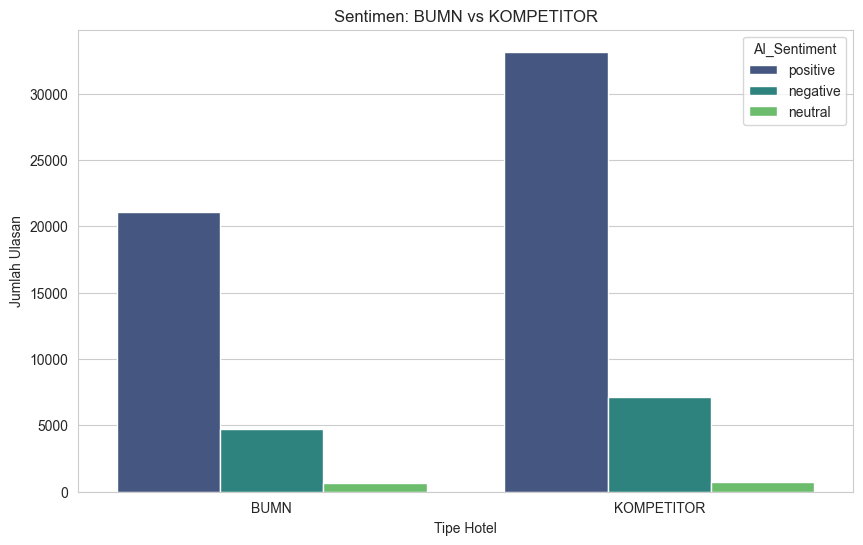

Grafik 2 Disimpan: ../Results/Visualisasi\2_Sentimen_per_Kelas.png


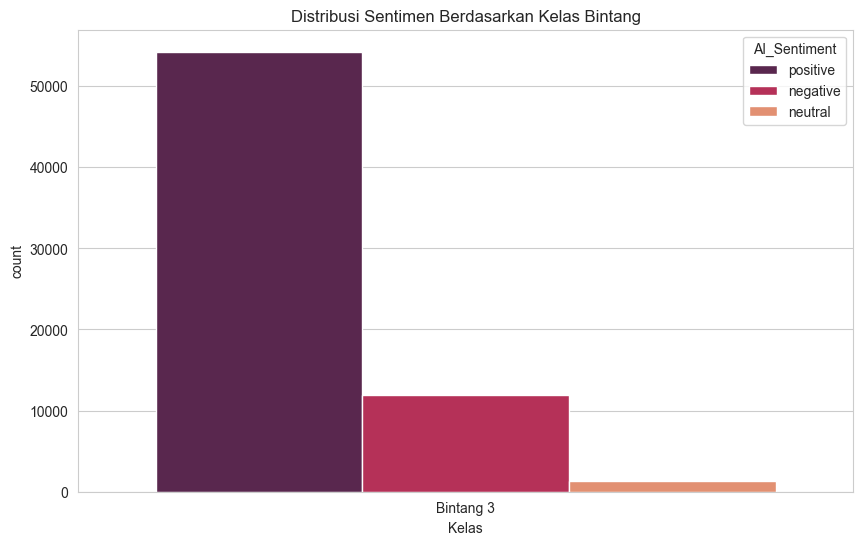

In [7]:
# CELL 7: VISUALISASI & SIMPAN PNG


# Grafik 1: Perbandingan Sentimen
plt.figure(figsize=(10, 6))
sns.countplot(data=df_result, x='Tipe', hue='AI_Sentiment', palette='viridis')
plt.title("Sentimen: BUMN vs KOMPETITOR")
plt.xlabel("Tipe Hotel")
plt.ylabel("Jumlah Ulasan")

# Simpan PNG
path_img1 = os.path.join(OUTPUT_IMG_PATH, "1_BUMN_vs_Kompetitor.png")
plt.savefig(path_img1, dpi=300, bbox_inches='tight')
print(f"Grafik 1 Disimpan: {path_img1}")
plt.show()

# Grafik 2: Sentimen per Kelas Bintang
if 'Kelas' in df_result.columns:
    plt.figure(figsize=(10, 6))
    order = sorted(df_result['Kelas'].unique())
    sns.countplot(data=df_result, x='Kelas', hue='AI_Sentiment', order=order, palette='rocket')
    plt.title("Distribusi Sentimen Berdasarkan Kelas Bintang")
    
    # Simpan PNG
    path_img2 = os.path.join(OUTPUT_IMG_PATH, "2_Sentimen_per_Kelas.png")
    plt.savefig(path_img2, dpi=300, bbox_inches='tight')
    print(f"Grafik 2 Disimpan: {path_img2}")
    plt.show()

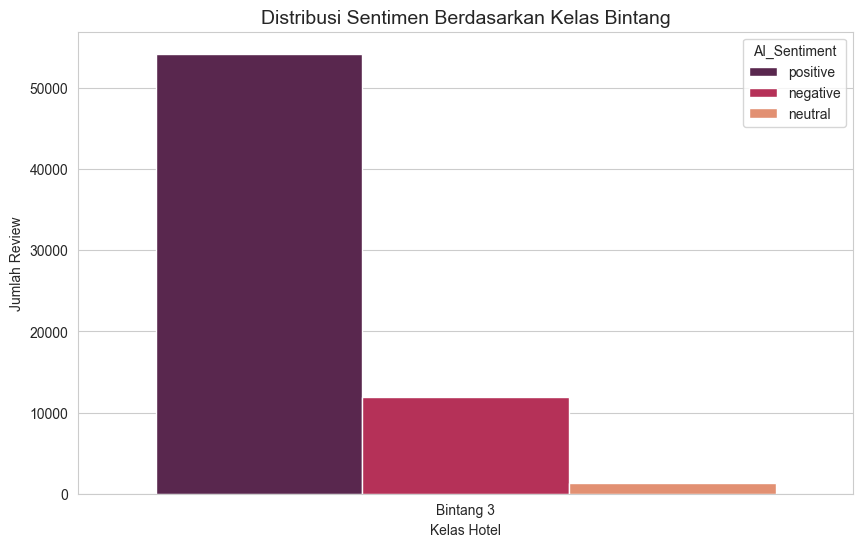

In [8]:
# CELL 8: GRAFIK 2 - PERBANDINGAN KELAS BINTANG

plt.figure(figsize=(10, 6))

try:
    # Urutkan agar grafik rapi (Bintang3 -> Bintang4 -> Bintang5)
    order_bintang = sorted(df_result['Kelas'].unique())
    
    sns.countplot(data=df_result, x='Kelas', hue='AI_Sentiment', order=order_bintang, palette='rocket')
    
    plt.title('Distribusi Sentimen Berdasarkan Kelas Bintang', fontsize=14)
    plt.xlabel('Kelas Hotel')
    plt.ylabel('Jumlah Review')
    plt.show()
except Exception as e:
    print(f"Gagal membuat grafik bintang: {e}")



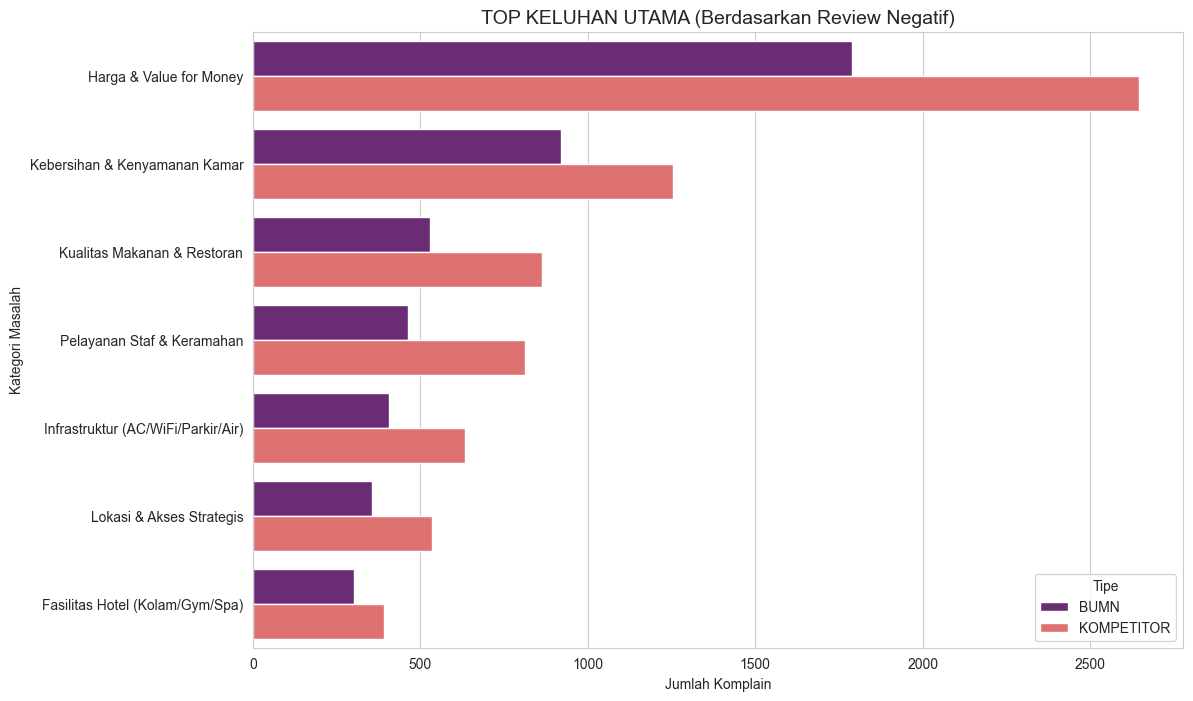

In [10]:
# CELL 9: GRAFIK 3 - PETA MASALAH (Review Negatif Saja)


# Filter: Ambil hanya yang sentimennya NEGATIVE
df_neg = df_result[df_result['AI_Sentiment'] == 'negative']

if not df_neg.empty:
    plt.figure(figsize=(12, 8))
    
    # Hitung aspek mana yang paling banyak dikeluhkan
    order_aspek = df_neg['AI_Aspek'].value_counts().index
    
    # Buat grafik horizontal
    sns.countplot(data=df_neg, y='AI_Aspek', hue='Tipe', order=order_aspek, palette='magma')
    
    plt.title('TOP KELUHAN UTAMA (Berdasarkan Review Negatif)', fontsize=14)
    plt.xlabel('Jumlah Komplain')
    plt.ylabel('Kategori Masalah')
    plt.show()
else:
    print("Wow! Tidak ada review negatif sama sekali.")